<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM MAP' Study</p><br>

# This notebook computes a sipm map needed for the NextFlex studies

In [15]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [50]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import time

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [131]:
from nextflex.sipm_map import sipm_pos
from nextflex.sipm_map import sipm_indx
from nextflex.sipm_map import find_pitch
from nextflex.core import NN
from nextflex.core import Setup

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [18]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# DATA

In [206]:
FDATA = os.environ['FLEXDATA']
print(f'path to data directories ={FDATA}')

path to data directories =/Users/jj/Development/flexdata


In [222]:
    # define setup
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6_P10.EL8bar")
print(setup)



        Setup <FLEX100_M6_O6_P10.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_P10.EL8bar
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        Fibres?                      = False
        


In [229]:
iPATH =  f"{FDATA}/{setup.tpConfig}"
print(iPATH)
ifnames = glob.glob(f"{iPATH}/*.h5")
pitch = find_pitch(ifnames[0])
print(f'for file {ifnames[0]} :  pitch ={pitch : 2.1f} mm ')


/Users/jj/Development/flexdata/FLEX100_M6_O6_P10.EL8bar
for file /Users/jj/Development/flexdata/FLEX100_M6_O6_P10.EL8bar/FLEX100_M6_O6_P10.Kr83.ACTIVE.3099.next.h5 :  pitch = 10.0 mm 


In [230]:
testFile = ifnames[1]

In [231]:
mcConfig = load_mcconfiguration(testFile)

In [232]:
mcConfig

,param_key,param_value
0,event_type,other
1,num_events,100
2,saved_events,100
3,interacting_events,100
4,PmtR11410_binning,0.025000 mus
...,...,...
74,/event/verbose,0
75,/tracking/verbose,0
76,/nexus/random_seed,993669
77,/nexus/persistency/start_id,308900


In [233]:
mcConfig.set_index("param_key", inplace = True)

In [234]:
mcConfig

,param_value
param_key,
event_type,other
num_events,100
saved_events,100
interacting_events,100
PmtR11410_binning,0.025000 mus
...,...
/event/verbose,0
/tracking/verbose,0
/nexus/random_seed,993669


In [235]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]

In [236]:
par

param_value           10.   mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

# Input data

In [237]:
# Verbosing main config parameters

main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
                   "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
                   "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
                   "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
                   "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]
print(mcConfig.loc[mcConfig.index.intersection(main_params)])


                                                param_value
param_key                                                  
num_events                                              100
TP_SiPM_binning                                1.000000 mus
/Geometry/NextFlex/e_lifetime                      1000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness              6.   mm
/Geometry/NextFlex/tp_teflon_hole_diam              6.   mm
/Geometry/NextFlex/tp_sipm_sizeX                   1.3   mm
/Geometry/NextFlex/tp_sipm_pitchX                  10.   mm


## Extract pitch from params

In [238]:
pitch

10.0

## SiPMs are at indices < 10000 in dataframes 

In [239]:
KEY_sensor_fibres  = 100000
KEY_sensor_pmts    = 100
sipm_index         = (KEY_sensor_pmts, KEY_sensor_fibres)

## Sensors

In [240]:
get_sensor_binning(testFile)

,bin_width
sns_name,
PmtR11410,25.0
TP_SiPM,1000.0


In [241]:
sns_types = get_sensor_types(testFile)
sns_types.head()

,sensor_id,sensor_name
0,42,PmtR11410
1,45,PmtR11410
2,30,PmtR11410
3,37,PmtR11410
4,0,PmtR11410


In [242]:
np.unique(sns_types.sensor_name.values)

array(['PmtR11410', 'TP_SiPM'], dtype=object)

In [243]:
sns_positions = load_mcsensor_positions(testFile)
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,42,PmtR11410,437.5,108.300003,1468.699951
1,45,PmtR11410,-437.5,-108.300003,1468.699951
2,30,PmtR11410,250.0,216.600006,1468.699951
3,37,PmtR11410,250.0,433.012695,1468.699951
4,0,PmtR11410,125.0,0.000000,1468.699951


## SiPM map

In [244]:
sipm_positions = sns_positions[in_range(sns_positions.sensor_id, *sipm_index)].reset_index()
sipm_positions.head()

,index,sensor_id,sensor_name,x,y,z
0,60,3491,TP_SiPM,-435.0,-125.0,-23.301001
1,61,7674,TP_SiPM,125.0,325.0,-23.301001
2,62,6299,TP_SiPM,-225.0,165.0,-23.301001
3,63,2766,TP_SiPM,-335.0,-205.0,-23.301001
4,64,7771,TP_SiPM,-315.0,345.0,-23.301001


In [245]:
XMAX = sipm_positions.x.max()
XMIN = sipm_positions.x.min()
YMAX = sipm_positions.y.max()
YMIN = sipm_positions.y.min()
print(f'XMAX = {XMAX} XMIN = {XMIN} YMAX = {YMAX} YMIN = {YMIN}')

XMAX = 485.0 XMIN = -485.0 YMAX = 485.0 YMIN = -485.0


In [246]:
sipm_map = sipm_pos(sipm_positions, pitch, eps=0.1)

In [247]:
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd
0,3491,TP_SiPM,-435.0,-125.0,-445.0,-425.0,-115.0,-135.0
1,7674,TP_SiPM,125.0,325.0,115.0,135.0,335.0,315.0
2,6299,TP_SiPM,-225.0,165.0,-235.0,-215.0,175.0,155.0
3,2766,TP_SiPM,-335.0,-205.0,-345.0,-325.0,-195.0,-215.0
4,7771,TP_SiPM,-315.0,345.0,-325.0,-305.0,355.0,335.0
...,...,...,...,...,...,...,...,...
7479,4477,TP_SiPM,-195.0,-25.0,-205.0,-185.0,-15.0,-35.0
7480,4331,TP_SiPM,305.0,-45.0,295.0,315.0,-35.0,-55.0
7481,5759,TP_SiPM,-5.0,105.0,-15.0,5.0,115.0,95.0
7482,4850,TP_SiPM,-385.0,15.0,-395.0,-375.0,25.0,5.0


In [248]:
sipm_indx(sipm_map)

In [249]:
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,3491,TP_SiPM,-435.0,-125.0,-445.0,-425.0,-115.0,-135.0,3490,3492,3585,3397
1,7674,TP_SiPM,125.0,325.0,115.0,135.0,335.0,315.0,7673,7675,7745,7601
2,6299,TP_SiPM,-225.0,165.0,-235.0,-215.0,175.0,155.0,6298,6300,6391,6207
3,2766,TP_SiPM,-335.0,-205.0,-345.0,-325.0,-195.0,-215.0,2765,2767,2855,2678
4,7771,TP_SiPM,-315.0,345.0,-325.0,-305.0,355.0,335.0,7770,7772,7839,7701
...,...,...,...,...,...,...,...,...,...,...,...,...
7479,4477,TP_SiPM,-195.0,-25.0,-205.0,-185.0,-15.0,-35.0,4476,4478,4575,4379
7480,4331,TP_SiPM,305.0,-45.0,295.0,315.0,-35.0,-55.0,4330,4332,4429,4234
7481,5759,TP_SiPM,-5.0,105.0,-15.0,5.0,115.0,95.0,5758,5760,5854,5663
7482,4850,TP_SiPM,-385.0,15.0,-395.0,-375.0,25.0,5.0,4849,4851,4948,4752


In [250]:
sipm_indx_test(sipm_map)

True

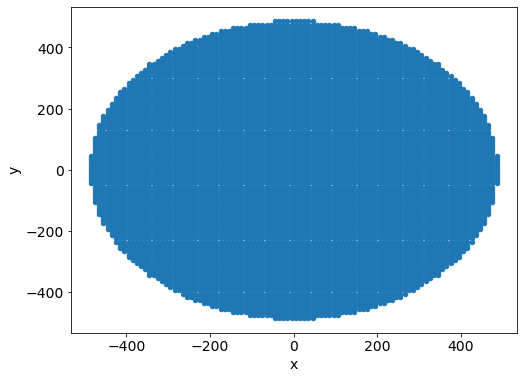

In [251]:
sipm_map.plot(kind='scatter', x='x', y='y')

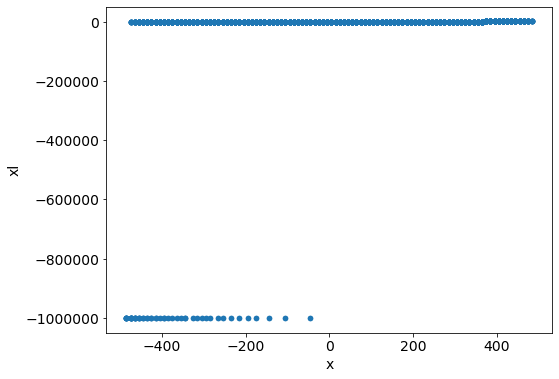

In [252]:
sipm_map.plot(kind='scatter', x='x', y='xl')

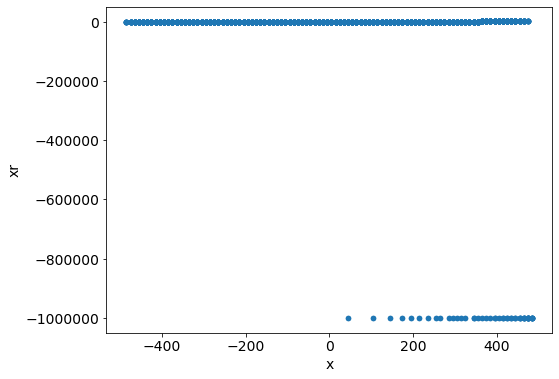

In [253]:
sipm_map.plot(kind='scatter', x='x', y='xr')

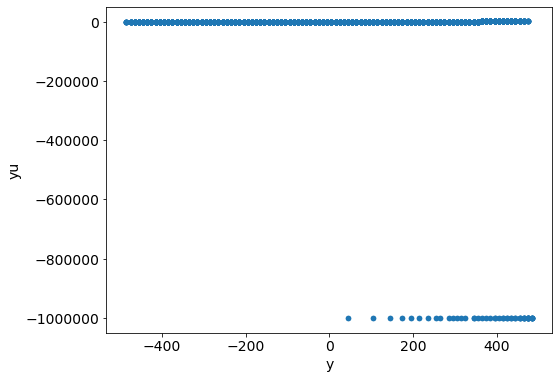

In [254]:
sipm_map.plot(kind='scatter', x='y', y='yu')

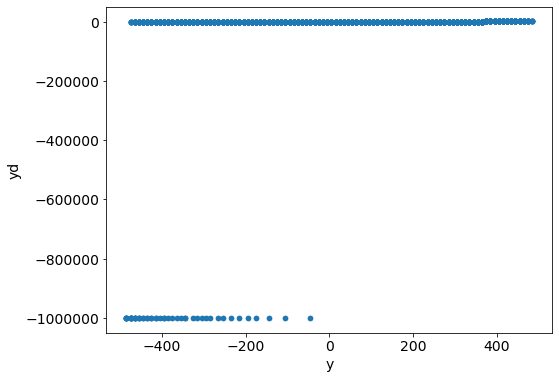

In [255]:
sipm_map.plot(kind='scatter', x='y', y='yd')

In [70]:
#sipm_map.to_csv('sipm_map.csv')